In this notebook, we're going to talk about some of the more sophisticated methods provided by `opencv` for image processing.

# Important: Run this code cell each time you start a new session!

In [2]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install opencv-python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [3]:
!wget -Ncnp https://images.fineartamerica.com/images-medium-large-5/coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg

--2023-07-19 21:08:35--  https://images.fineartamerica.com/images-medium-large-5/coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg
Resolving images.fineartamerica.com (images.fineartamerica.com)... 18.65.229.77, 18.65.229.68, 18.65.229.33, ...
Connecting to images.fineartamerica.com (images.fineartamerica.com)|18.65.229.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278914 (272K) [image/jpeg]
Saving to: ‘coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg’

coloured-mri-scan-o 100%[===================>] 272.38K  --.-KB/s    in 0.03s   

2023-07-19 21:08:35 (8.23 MB/s) - ‘coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg’ saved [278914/278914]



In [4]:
import shutil
import os
orig_file = os.path.join('coloured-mri-scan-of-brain-in-sagittal-se-geoff-tompkinson.jpg')

os.rename(orig_file, 'color_mri.jpg')

# Canny Edge Detection

The edge detection kernels we looked at earlier simply generated a series of numbers that represented the prominence of the edges at each pixel of the image. However, this is a far cry from definitively telling us where the edges are and aren't. What we really want is a binary image with thin lines that trace around the major objects in our image.

One way to do this is by using the ***Canny Edge Detection algorithm***. The steps of this algorithm are as follows:
1. Smooth the image to reduce noise
2. Apply Sobel operators to find the magnitude of the gradient at each location
3. Use a technique called ***non-maximum suppression*** to identify the largest gradients near regions with lots of non-trivial gradients bunched together (e.g., thick edges)
4. Threshold the gradients to keep only the prominent edges
5. Reintroduce some pixels that would complete edges with gaps as long as they have a reasonably high gradient

We've already covered how to perform steps 1, 2, and 4. The other steps are a bit more complicated, but fortunately, we don't need to do any of this ourselves.

`opencv` provides a function called `cv2.Canny()` that detects edges for us using this procedure. The function takes three parameters at minimum:
1. **img:** The binary image from which we want to find edges
2. **threshold1:** The minimum gradient magnitude of pixels that *could belong* to edges
3. **threshold2:** The minimum gradient magnitude of pixels that *must belong* to edges

The output of this function is a binary image that only has two values: 0 (black) and 255 (white).

Determining the two threshold values is typically a matter of trial-and-error. In general, lower threshold values will produce more edges. Play around with their values in the example below and see what you can come up with:

In [35]:
# Load the image
img = cv2.imread('color_mri.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

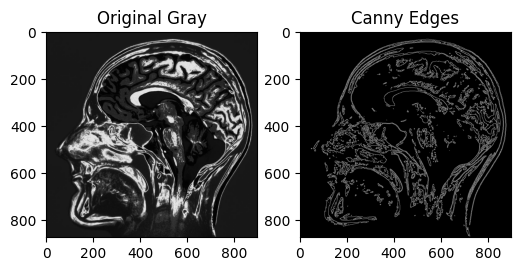

In [31]:
threshold1 = 190 #@param {type:"slider", min:0, max:255, step:5}
threshold2 = 235 #@param {type:"slider", min:0, max:255, step:5}

# Check that the thresholds are reasonable
if threshold1 >= threshold2:
    raise Exception('threshold1 should be less than threshold2')

# Apply the edge detector
edges_img = cv2.Canny(gray_img, threshold1=threshold1, threshold2=threshold2)

# Show the results
plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1), plt.imshow(gray_img, cmap='gray'), plt.title('Original Gray')
plt.subplot(1, 2, 2), plt.imshow(edges_img, cmap='gray'), plt.title('Canny Edges')
plt.show()

# Contour Detection

Edges are great, but most people want to detect edges in order to find shapes. `opencv` provides a function called `cv2.findContours()` to extract the outlines of all the contiguous blobs in a binary image. This algorithm is based on the following paper:

> Suzuki, S. and Abe, K., Topological Structural Analysis of Digitized Binary Images by Border Following. CVGIP 30 1, pp 32-46 (1985)

As the title of the paper implies, the algorithm involves tracing edges that can be readily identified in a binary image.

The `cv2.findContours()` function requires the following parameters:
1. **img:** The binary image from which we want to identify shapes
2. **mode:** A special variable that specifies how the list of contours are arranged. For example, `cv2.RETR_EXTERNAL` retrieves only the extreme outer contours, `cv2.RETR_TREE` provides a hierarchical structure that indicates which contours are contained in one another, and `cv2.RETR_LIST` provides all of the contours in a list without any structure.
3. **method:** A special variable that specifies how many data points are included in each contour. `cv2.CHAIN_APPROX_NONE` provides every point included in each contour, while  `cv2.CHAIN_APPROX_SIMPLE` provides the minimum number of points to accurately represent each contour.



The function provides two outputs:
1. **contours:** A list of `numpy` arrays that contain the (x, y) boundary coordinates of each blob
2. **hierarchy:** An optional data structure that specifies which contours are contained in one another

Here is the function in action:

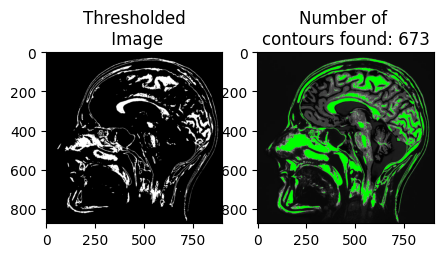

In [109]:
brightness_threshold = 170 #@param {type:"slider", min:0, max:255, step:5}

# Binarize the image to only keep the bright regions
_, thresh_img = cv2.threshold(gray_img, brightness_threshold, 255, cv2.THRESH_BINARY)

# Locate the contours
cnts, hierarchy = cv2.findContours(thresh_img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
output = gray_img.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2RGB)
for cnt in cnts:
	cv2.drawContours(output, [cnt], -1, (0, 255, 0), -1)

# Show the results
plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1), plt.imshow(thresh_img, cmap='gray'), plt.title('Thresholded\n Image')
plt.subplot(1, 2, 2), plt.imshow(output), plt.title(f'Number of \ncontours found: {len(cnts)}')
plt.show()

Given the complexity of this image, we have quite a few contours:
* Some contours are small and significant due to noise / speckling in the image
* Some contours corresponding to individual regions of the brain are potentally and unintentionally split up into multiple subregions
* Some contours are contained within others (e.g., parts of the brain that lie inside the skull)

We won't go through every possible technique we can do to improve our results, but here are a couple:
1. Before we even threshold our image, we can smooth it out with a blur filter to reduce the noisiness of the binary image that goes into the `cv2.findContours()` function.
2. Once the contours have been identified, we can check whether they satisfy a certain criteria (e.g., size, location).

Regarding the second point, there are a slew of contour properties we can calculate using `opencv`. Some of these properties are outlined below:

| Function | Purpose |
|:--------:|:-------|
| `cv2.moments()` | Calculates properties of the contour's shape to identify features like the center of mass |
| `cv2.contourArea()` | Calculates the area of the contour |
| `cv2.arcLength()` | Calculates the perimeter of the contour |
| `cv2.isContourConvex()` | Checks whether the shape is convex (i.e., all sides are curved outward) |
| `cv2.convexHull()` | Approximates the shape of the contour as the smallest convex polygon containing all the given points |
| `cv2.boundingRect()` | Calculates the smallest upright rectangle that will fit all the points in the contour |
| `cv2.minAreaRect()` | Calculates the smallest rotated rectangle that will fit all the points in the contour |
| `cv2.minEnclosingCircle()` | Calculates the smallest circle that will fit all the points in the contour |
| `cv2.fitEllipse()` | Calculates the smallest ellipse that will fit all the points in the contour |

To improve our contour detection algorithm from earlier, we will smooth our image and use `cv2.contourArea()` to ensure that we only keep reasonably-sized contours.

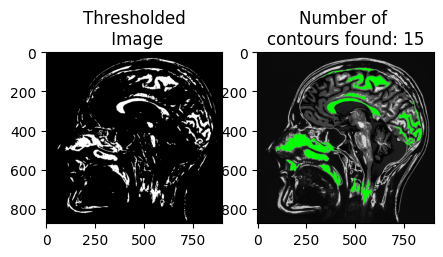

In [108]:
brightness_threshold = 170 #@param {type:"slider", min:0, max:255, step:5}
blur_kernel_size = 15 #@param {type:"slider", min:3, max:31, step:2}
min_area = 1000 #@param {type:"slider", min:0, max:4000, step:500}
max_area = 13000 #@param {type:"slider", min:0, max:15000, step:500}

if min_area > max_area:
    raise Exception("min_area should be less than max_area")

# Smooth the image
blur_img = cv2.GaussianBlur(gray_img,
                            ksize=(blur_kernel_size, blur_kernel_size), sigmaX=1)

# Binarize the image to only keep the bright regions
_, thresh_img = cv2.threshold(blur_img, brightness_threshold, 255, cv2.THRESH_BINARY)

# Locate the contours
cnts, hierarchy = cv2.findContours(thresh_img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Only keep the contours that pass the size check
final_cnts = []
for cnt in cnts:
    cnt_area = cv2.contourArea(cnt)
    if min_area < cnt_area < max_area:
        final_cnts.append(cnt)

# Draw the contours on the original image
output = gray_img.copy()
output = cv2.cvtColor(output, cv2.COLOR_GRAY2RGB)
for cnt in final_cnts:
    cv2.drawContours(output, [cnt], -1, (0, 255, 0), -1)

# Show the results
plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1), plt.imshow(thresh_img, cmap='gray'), plt.title('Thresholded\n Image')
plt.subplot(1, 2, 2), plt.imshow(output), plt.title(f'Number of \ncontours found: {len(final_cnts)}')
plt.show()

# Summary

During this session, we went from talking about the color of a single pixel to identifying shapes in an entire image. These methods form the building blocks of many image processing pipelines.

Even though deep learning has become the industry standard for performing tasks with images, being comfortable with thinking about images as multidimensional arrays will be a major step in working to that point.